### Import required libraries for data acquisition

In [1]:
import pickle
from os import listdir, getcwd
from os.path import dirname, abspath, join
import cv2
import numpy as np

Global variabels

In [2]:
seq_length = 20
is_sequential = True
is_pca = True

Load Data from `.pickle` files

In [3]:
data = {}
data_dir = abspath(dirname(getcwd()))
for f in listdir(data_dir):
    if '.pickle' in f:
        data_path = join(data_dir, f)
        with open(data_path, 'rb') as fp:
            data[data_path.split('/')[-1].split('.')[0]] = pickle.load(fp)

Convert list data to numpy array (`np.ndarray`)

In [4]:


def data_to_numpy(data: list) -> np.array:
    arr = np.empty((len(data),len(data[0]), len(data[0][0])), np.float64)
    for i in range(len(data)):
        for j in range(len(data[0])):
            arr[i, j, :] = [data[i][j]['x'], data[i][j]['y'], data[i][j]['z']]
    return arr

In [5]:
def generate_data(data, type_='all', is_sequential=False, seq_length=10):

    final_data = []
    if type_ == 'l':
        arr_l = np.concatenate((data_to_numpy(data['l_s']), data_to_numpy(data['l_ns'])), axis=0)
        arr_nl = np.concatenate((data_to_numpy(data['nl_s']), data_to_numpy(data['nl_ns'])), axis=0)
        if is_sequential:
            arr_l = to_sequential(arr_l, seq_length=seq_length)
            arr_nl = to_sequential(arr_nl, seq_length=seq_length)
        y = np.concatenate((np.zeros(arr_l.shape[0]), np.ones(arr_nl.shape[0])), axis=0)

        final_data = [np.concatenate((arr_l, arr_nl), axis=0), y, ['looking', 'not_looking']]
    
    elif type_ == 's':
        arr_s = np.concatenate((data_to_numpy(data['l_s']), data_to_numpy(data['nl_s'])), axis=0)
        arr_ns = np.concatenate((data_to_numpy(data['l_ns']), data_to_numpy(data['nl_ns'])), axis=0)
        if is_sequential:
            arr_s = to_sequential(arr_s, seq_length=seq_length)
            arr_ns = to_sequential(arr_ns, seq_length=seq_length)
        y = np.concatenate((np.zeros(arr_s.shape[0]), np.ones(arr_ns.shape[0])), axis=0)
        
        final_data = [np.concatenate((arr_s, arr_ns), axis=0), y, ['speaking', 'not_speaking']]
    
    elif type_ == 'all':
        l_s = data_to_numpy(data['l_s'])
        nl_s = data_to_numpy(data['nl_s'])
        l_ns = data_to_numpy(data['l_ns'])
        nl_ns = data_to_numpy(data['nl_ns'])
        if is_sequential:
            l_s = to_sequential(l_s, seq_length=seq_length)
            nl_s = to_sequential(nl_s, seq_length=seq_length)
            l_ns = to_sequential(l_ns, seq_length=seq_length)
            nl_ns = to_sequential(nl_ns, seq_length=seq_length)
        X = np.concatenate((l_s, nl_s, l_ns, nl_ns), axis=0)
        y = np.concatenate((np.zeros(l_s.shape[0]), np.ones(nl_s.shape[0]), np.ones(l_ns.shape[0])*2, np.ones(nl_ns.shape[0])*3), axis=0)

        final_data = [X, y, ['looking_speaking', 'not_looking_speaking', 'looking_not_speaking', 'not_looking_not_speaking']]
    
    return final_data

In [6]:
def standardize_data(data, axis_, center=True, scale=True):
    shape_ = list(data.shape)
    shape_[axis_] = 1
        
    if center:
        data = data - data.mean(axis=axis_).reshape(*shape_)
    if scale:
        data = data - data.min(axis=axis_).reshape(*shape_)
        data = data / (data.max(axis=axis_) - data.min(axis=axis_)).reshape(*shape_)

    return data

def to_sequential(data: np.ndarray, seq_length: int=10, axis: int=1) -> np.ndarray:
    '''Transforms to sequential data

        # sp_cls[0] = 1 if np.sum(np.abs(s[0, 13] - s[0, 14])) > 0.025 else 0
        # txt = 'speaking' if np.sum(sp_cls)/2 >= 0.5 else 'not speaking'
    Parameters
    ----------
    data: np.ndarray
        The data to be processed
    seq_length: int
        The total number of consequent samples that would be used
        to generate the sequential data
    axis: int
        The nex axis where the sequences would be put in

    Returns
    -------
        np.ndarray
        The transformed sequential data

    '''

    shape_ = tuple(val - seq_length + 1 if i == 0 else val for i, val in enumerate(data.shape))
    shape_ = shape_[:axis] + (seq_length,) + shape_[axis:]
    seq_data = np.zeros(shape_)
    for i in range(data.shape[0]-seq_length+1):
        seq_data[i, :, :, :] = data[i:i+seq_length, :, :]
    return seq_data


In [12]:
from sklearn.decomposition import PCA

X, y, label_text = generate_data(data, type_='l', is_sequential=is_sequential, seq_length=20)
X = standardize_data(X, axis_=2)
X_dec = np.copy(X.reshape(X.shape[0], -1))
pca = PCA(n_components=50)
X_dec = pca.fit_transform(X_dec)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dec, y, test_size=0.3, random_state=1)

from sklearn import svm
from sklearn.metrics import accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# clf = AdaBoostClassifier(n_estimators=150, random_state=0)
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#     max_depth=1, random_state=0)
# clf = GaussianNB()
# clf = KNeighborsClassifier(n_neighbors=3)
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

accuracy = {}
clfs = {}
for name, clf in zip(names, classifiers):
    clfs[name] = clf
    clfs[name].fit(X_train, y_train)
    y_pred = clfs[name].predict(X_test)
    accuracy[name] = accuracy_score(y_test, y_pred)



/home/vision/.cache/pypoetry/virtualenvs/data-extraction-WtZGDk9M-py3.8/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [11]:
clfs['PCA'] = pca
with open('models.pkl','wb') as f:
    pickle.dump(clfs,f)

In [14]:
import pandas as pd

df = pd.DataFrame(accuracy.items(), columns=['Classifier', 'Accuracy'])
df = df.reset_index(drop=True)
df

,Classifier,Accuracy
0,Nearest Neighbors,0.997927
1,Linear SVM,1.000000
2,RBF SVM,0.601554
3,Gaussian Process,1.000000
4,Decision Tree,1.000000
5,Random Forest,0.875648
6,Neural Net,1.000000
7,AdaBoost,0.999482
8,Naive Bayes,0.974611
9,QDA,1.000000


In [31]:
# dfs_with_captions = {key: pd.DataFrame(val) for key, val in df['Classifier', 'Accuracy'].items()}
# display_side_by_side(dfs_with_captions, cmaps[10])
cmaps = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
cmaps2 = [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']
df.style.background_gradient(cmap=cmaps[10])

,Classifier,Accuracy
0,Nearest Neighbors,0.990211
1,Linear SVM,0.986605
2,RBF SVM,0.997939
3,Gaussian Process,0.998454
4,Decision Tree,0.990726
5,Random Forest,0.831530
6,Neural Net,0.995363
7,AdaBoost,0.951056
8,Naive Bayes,0.992787


In [15]:
import mediapipe as mp
from protobuf_to_dict import protobuf_to_dict

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh



In [51]:
import cv2
import numpy as np

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
clf = clfs['Gaussian Process']
record_video = False
sp_cls = np.zeros(seq_length)
max_num_faces=1
refine_landmarks=True
min_detection_confidence=0.5
min_tracking_confidence=0.5
with mp_face_mesh.FaceMesh(
        max_num_faces=max_num_faces,
        refine_landmarks=refine_landmarks,
        min_detection_confidence=min_detection_confidence,
        min_tracking_confidence=min_tracking_confidence,
    ) as face_mesh:
    cap = cv2.VideoCapture('vid2.mp4')

    # Check if camera opened successfully
    if (cap.isOpened()== False):
      print("Error opening video stream or file")

    # Read until video is completed
    if record_video:
      frame_width = int(cap.get(3))
      frame_height = int(cap.get(4))
        
      size = (frame_width, frame_height)
      out = cv2.VideoWriter('output_videos/is_looking.mp4', 
                          cv2.VideoWriter_fourcc(*'MJPG'),
                          10, size)
    count = 0
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        # image.flags.writeable = False
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

        # Draw the face mesh annotations on the image.
        # image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # add facelandmarks to the keypoints listimage
                keypoint = protobuf_to_dict(face_landmarks)["landmark"]
        else:
          continue

        s = np.array([[i['x'], i['y'], i['z']] for i in keypoint])
        s = np.expand_dims(s, axis=0)
        # s = s[:, upper_lip + lower_lip, :]
        # s = s[:, upper_lip, :] - s[:, lower_lip, :]
        # s = standardize_data(s, axis_=1)
        if is_sequential:
          if count == 0:
            seq_frames = s
            count += 1
            continue
          elif count < seq_length - 1:
            seq_frames = np.concatenate((seq_frames, s), axis=0)
            count += 1
            continue
          elif count == seq_length - 1:
            seq_frames = np.concatenate((seq_frames, s), axis=0)
            count += 1
          else:
            seq_frames = np.roll(seq_frames, -1, axis=0)
            seq_frames[seq_length-1] = s
        else:
          inference_frame = s.reshape(1, -1)


        # break
        if is_sequential:
          inference_frame = np.expand_dims(seq_frames, axis=0)
          inference_frame = standardize_data(inference_frame, axis_=2)
          inference_frame = inference_frame.reshape(1, -1)

          # print(inference_frame.shape)
          # break
        else:
          inference_frame = standardize_data(inference_frame, axis_=1)
          inference_frame = inference_frame.reshape(1, -1)

        inference_frame = pca.transform(inference_frame) if is_pca else inference_frame

        y_pred = clf.predict(inference_frame)
        print(label_text[int(y_pred)])
        # print(f'diff: {s[]}')
        # sp_cls = np.roll(sp_cls, 1, axis=0)
        # sp_cls[0] = 1 if np.sum(np.abs(s[0, upper_lip] - s[0, lower_lip])) > 0.5 else 0
        # txt = 'speaking' if np.sum(sp_cls)/2 >= 0.5 else 'not speaking'
        # txt = str(np.sum(np.abs(s[0, upper_lip] - s[0, lower_lip])))
        window_name = 'Image'
  
        # font
        font = cv2.FONT_HERSHEY_SIMPLEX
        # org
        org = (50, 50)
          
        # fontScale
        fontScale = 0.5
          
        # Blue color in BGR
        color = (255, 0, 0)
          
        # Line thickness of 2 px
        thickness = 2
          
        # Using cv2.putText() method
        image = cv2.putText(image, label_text[int(y_pred)], org, font, fontScale, color, thickness, cv2.LINE_AA)
        # image = cv2.putText(image, txt, org, font, fontScale, color, thickness, cv2.LINE_AA)
        # print(label_text[int(y_pred)])
        # break
        # Display the resulting frame
        if record_video:
          out.write(image)
        cv2.imshow('Frame',image)

        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break

      # Break the loop
      else: 
        break

    # When everything done, release the video capture object
    cap.release()
    if record_video:
      out.release()

# Closes all the frames
cv2.destroyAllWindows()

looking
looking
looking


QObject::moveToThread: Current thread (0x55c003d25e60) is not the object's thread (0x55c004ac4250).
Cannot move to target thread (0x55c003d25e60)

QObject::moveToThread: Current thread (0x55c003d25e60) is not the object's thread (0x55c004ac4250).
Cannot move to target thread (0x55c003d25e60)

QObject::moveToThread: Current thread (0x55c003d25e60) is not the object's thread (0x55c004ac4250).
Cannot move to target thread (0x55c003d25e60)

QObject::moveToThread: Current thread (0x55c003d25e60) is not the object's thread (0x55c004ac4250).
Cannot move to target thread (0x55c003d25e60)

QObject::moveToThread: Current thread (0x55c003d25e60) is not the object's thread (0x55c004ac4250).
Cannot move to target thread (0x55c003d25e60)

QObject::moveToThread: Current thread (0x55c003d25e60) is not the object's thread (0x55c004ac4250).
Cannot move to target thread (0x55c003d25e60)

QObject::moveToThread: Current thread (0x55c003d25e60) is not the object's thread (0x55c004ac4250).
Cannot move to tar

looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
not_looking
not_looking
not_looking
not_looking
not_looking
not_looking
not_looking
not_looking
not_looking
not_looking
not_looking
not_looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking
looking


In [10]:
var = np.var(X, axis=0)
var[:, 0].shape

(20, 3)

In [11]:
g = np.concatenate((data_to_numpy(data['l_ns']), data_to_numpy(data['nl_ns'])), axis=0)
g = standardize_data(g, axis_=1)
g.shape

(3226, 478, 3)

In [12]:
var = np.var(g, axis=0)
var[:, 0].shape

(478,)

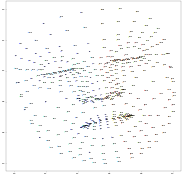

In [50]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

csfont = {'fontname':'Times New Roman'}

figure(figsize=(15, 15), dpi=15)
# g.shape
f = g[1000, :, 0:2]
# f.shape
# f = arr_s[750, :, 0:2]
# fig, axs = plt.subplots(nrows=1, ncols=1)
plt.scatter(f[:, 0], f[:, 1], s=5, c=np.arange(478), cmap='jet')
for i in range(478):
    plt.annotate(str(i), (f[i, 0], f[i, 1]))
# plt.subplots_adjust(wspace = .5)
# for i in range(3):
#     pcm = axs[i].scatter(f[:, 0], f[:, 1], s=5, c=var[:, i], cmap='jet')
#     axs[i].invert_yaxis()
#     fig.colorbar(pcm, ax=axs[i], orientation='horizontal')
plt.gca().invert_yaxis()
plt.show()

<Figure size 14400x1800 with 0 Axes>

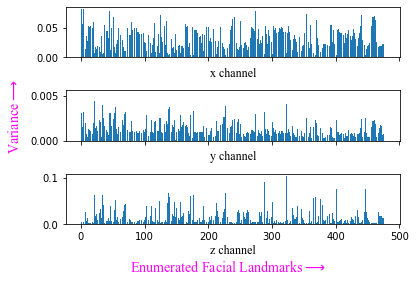

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

figure(figsize=(240, 30), dpi=60)

channel = ['x', 'y', 'z']
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True)
for i in range(3):
    axs[i].bar(np.arange(var.shape[0]), var[:, i])
    if i == 2:
        axs[i].set_title(f'{channel[i]} channel', y=-0.7, **csfont)
    else:
        axs[i].set_title(f'{channel[i]} channel', y=-0.5, **csfont)
    # axs[i].set_xlabel('Facial Landmarks')
    # axs[i].set_ylabel('Variance')
fig.subplots_adjust(hspace=0.65)
fig.text(0.5, -0.04, f'Enumerated Facial Landmarks$\longrightarrow$', ha='center', **csfont, size=14, color='magenta')
fig.text(-0.01, 0.5, 'Variance$\longrightarrow$', va='center', rotation='vertical', **csfont, size=14, color='magenta')
plt.show()

<Figure size 12800x1600 with 0 Axes>

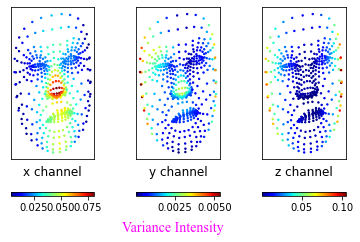

In [87]:
from matplotlib.pyplot import figure

figure(figsize=(160, 20), dpi=80)
f = g[750, :, 0:2]
fig, axs = plt.subplots(nrows=1, ncols=3)
plt.subplots_adjust(wspace = .5)
for i in range(3):
    pcm = axs[i].scatter(f[:, 0], f[:, 1], s=2, c=var[:, i], cmap='jet')
    axs[i].invert_yaxis()
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f'{channel[i]} channel', y=-0.15)
    fig.colorbar(pcm, ax=axs[i], orientation='horizontal')

fig.text(0.5, 0.1, 'Variance Intensity', ha='center', **csfont, size=14, color='magenta')
plt.show()


In [193]:
import cv2
from IPython.display import display, Image

video = cv2.VideoCapture('lnlns.mp4')
display_handle=display(None, display_id=True)
try:
    while video.isOpened():
        _, frame = video.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None